# NetworkX Exploration

By: Tyler Biggs

## Package imports and notebook setup

In [1]:
# Import networkx, and general Python applications.
import networkx as nx
import random
import numpy as np
import collections

# Plotting tools.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# Setup matplotlib for nice notebook output.
# Commands that begin with a `%` are `magic` jupyter-notebook
# specific functions.
%matplotlib notebook

## Importing Data

Right now this is specific to my system. I will update for CoCalc implementation later.

In [3]:
# Assign the data path.
# I removed the first two lines, an empty line and a line
# that contained the count. (for simplicity)
data_path = 'data/water1.xyz'

In [4]:
# Open and close the file in a pythonic way.
# The file will be closed once we exit the `with` statement.
with open(data_path) as my_file:
    water_data = my_file.read()

In [5]:
# De-comment and run to view the messy state of `water_data`.
# print(water_data)

In [50]:
# Split the giant string generated above into a list.
# This also removes the newline characters, `/n`.
water_data = water_data.splitlines()

AttributeError: 'list' object has no attribute 'splitlines'

In [7]:
# De-comment and run to view the clean, but large output
# of `water_data`.
# print(water_data)

In [8]:
# Now examine the first, last, and some random lines.
print(f'The first line:\n\t{water_data[0]}')
print(f'The last line:\n\t{water_data[-1]}')
print(f'Some randome line:\n\t{random.choice(water_data)}')

The first line:
	O     0.154966E+01  0.112994E+02  0.150422E+02
The last line:
	H     0.133676E+02  0.492056E+01  0.127673E+02
Some randome line:
	O     0.133417E+02  0.164232E+02  0.151154E+02


## Creating a graph

From the `networkx` documentation.

> By definition, a Graph is a collection of nodes (vertices) along with identified pairs of nodes (called edges, links,
etc). In NetworkX, nodes can be any hashable object e.g., a text string, an image, an XML object, another Graph, a
customized node object, etc.

### Adding nodes with positional information

There is no magic from the networkx package here. I simply assign nodes as strings built from their atom type and line number in the list. I then add a python dictionary I name `xyz` that will hold the list of x, y, z coordinates.

In [9]:
# Create an empty graph object.
# I place this in the same code block as the loop below to
# ensure that the graph is empty each time the data is
# added to the graph.
test_graph = nx.Graph()

# For each item in the water_data list I will create a node.
# I use Python's enmuerate to easily match an index to the
# current item in the for loop.
for index, item in enumerate(water_data):
    
    # The item at this point is still a single string, so
    # now I will break each line into sub-lists.
    # The split() function splits by whitespace as a default.
    line = item.split()
    
    # I will name the node based on its position. The list
    # created has 4 entries, the first is the atom element,
    # the next three are the x, y and z coordinates.
    node_name = f'{line[0]}-{index}'
    
    # Now I will get the actual numbers from the list.
    # I chose to use numpy, it is standard practice.
    # Here I use Python's splice notation to grab everythin
    # from the second item to the end of the list.
    # Also used is a `generator`. It is a faster and more
    # succint way to process lists.
    line_coords = [np.float(x) for x in line[1:]]
    
    # Create the actual node.
    test_graph.add_node(node_name, xyz=line_coords)

#### State of the graph

The graph has a bunch of nodes that have no edges inbetween them. The nodes do however, have their x, y, z positions attached to them. We should at least be able to generate a scatter plot.

In [10]:
# Getting attributes from our graph.
test_coords = nx.get_node_attributes(test_graph, 'xyz')

# This gives us a dictionary, which isn't great for
# the plotting tools. Instead matplotlib would rather
# have separate lists of x, y and z values.
x_vals = [x[0] for x in test_coords.values()]
y_vals = [x[1] for x in test_coords.values()]
z_vals = [x[2] for x in test_coords.values()]

In [11]:
color_dict = {
    'H': 'red',
    'O': 'blue',
}

size_dict = {
    'H': 25,
    'O': 60,
}

In [12]:
c_vals = [color_dict[x[0]] for x in test_coords.keys()]
s_vals = [size_dict[x[0]] for x in test_coords.keys()]

### Plotting the X, Y, Z coordinates

<IPython.core.display.Javascript object>


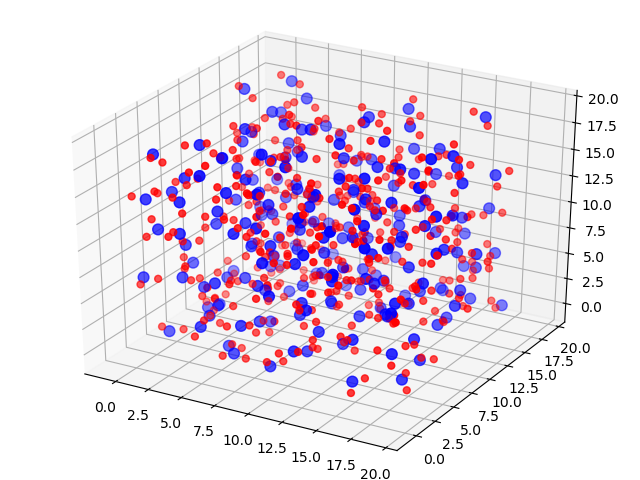

In [13]:
# Declare the figure object.
fig = plt.figure()

# Declare an axis object within / on the figure object.
# See the below link for a discussion of matplotlib's subplot.
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html
ax = Axes3D(fig)

# Add the points to the scatter plot.
ax.scatter(x_vals, y_vals, z_vals, c=c_vals, s=s_vals)

# Show the plot.
plt.show()

## Adding Edges

This is where things become less clear...

### Finding Water Molecules

I see lots of sets of three nodes in the above scatter plot. Linking together individual waters seems like a reasonable place to start.

## Creating Distance Matricies

[I have no idea what I am doing](http://i0.kym-cdn.com/entries/icons/original/000/008/342/ihave.jpg)

In [14]:
# Import progress bars, these operations could take some time...
from tqdm import tnrange, tqdm_notebook

In [15]:
# Find the length / number of atoms in the system.
test_atoms_total = len(test_coords)

In [16]:
test_distance_matrix = np.zeros((test_atoms_total, test_atoms_total))

In [17]:
# These should be the indicies 
it, jt = np.triu_indices(test_atoms_total)

In [18]:
# Convert the coordinate dictionary values to a numpy
# array. This is needed for easier and faster transforms.
xyz_vals = np.array([x for x in test_coords.values()])

In [19]:
for x in tqdm_notebook([x for x in zip(it, jt)]):
    coord_a = xyz_vals[x[0]]
    coord_b = xyz_vals[x[1]]
    
    test_distance_matrix[x[0], x[1]] = np.linalg.norm(coord_a - coord_b)

HBox(children=(IntProgress(value=0, max=210276), HTML(value='')))

## Examining Distance Matrixes

In [20]:
oxygen_water_range = [0, 1.2]
hydrogen_bond_range = [1.2, 2.6]

In [21]:
# Enemerate through each entry of the distance matrix.
# Each entry, x, is a list of distances to other atoms.
# Their index is the same as their corresponding nodes.
for i, x in tqdm_notebook(enumerate(test_distance_matrix)):
    
    # For each indexed distance, check criteria.
    for j, dist in enumerate(x):
        if oxygen_water_range[0] < dist <= oxygen_water_range[1]:
            # Then add an edge between the i and j nodes.
            test_graph.add_edge(i, j)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

## Plot Added Edges

<IPython.core.display.Javascript object>


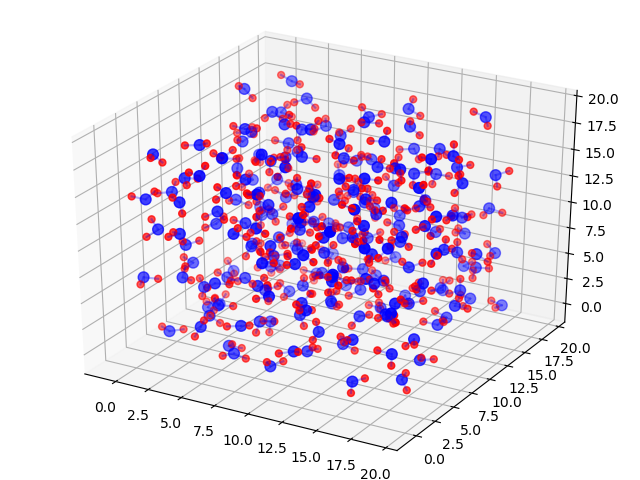

HBox(children=(IntProgress(value=0, max=432), HTML(value='')))

In [22]:
# Declare the figure object.
fig = plt.figure()

# Declare an axis object within / on the figure object.
# See the below link for a discussion of matplotlib's subplot.
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html
ax = Axes3D(fig)

# Add the points to the scatter plot.
ax.scatter(x_vals, y_vals, z_vals, c=c_vals, s=s_vals)

# Iterate through the edges, and draw line segments for each set.
for edge in tqdm_notebook(test_graph.edges()):
    
    # Assign the node edge indecies.
    node_a = edge[0]
    node_b = edge[1]
    
    # Assign the x, y, z variables.
    xa, ya, za = xyz_vals[node_a]
    xb, yb, zb = xyz_vals[node_b]

    # Get the xyz coordinates for each node, and draw a segment.
    ax.plot([xa, xb], [ya, yb], [za, zb], color='b', alpha=0.3)

# Show the plot.
plt.show()    

<IPython.core.display.Javascript object>


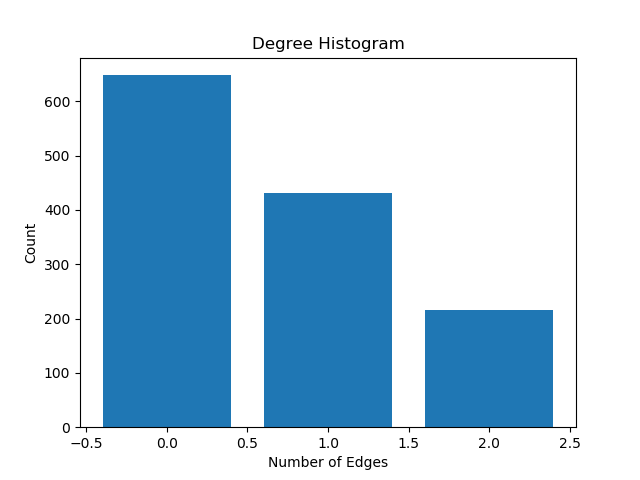

In [24]:
# Create and sort a list of number edges each node has.
degree_sequence = sorted([d for n, d in test_graph.degree()], reverse=True)  # degree sequence
# print("Degree sequence", degree_sequence)

# Count the instance of each count.
degreeCount = collections.Counter(degree_sequence)

# Create lists for use in histogram plotting.
deg, cnt = zip(*degreeCount.items())

# Declare the figure object.
# This time get the axis as well.
fig = plt.figure()
plt.bar(deg, cnt)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Number of Edges")
plt.show()

### Avoiding Hard-coding some things...

### Graph Generation

It's better for testing to begin with a clean instance of the graph. Defining some functions can make this exploration easier.

In [23]:
def generate_graph(data_path='data/water1.xyz'):
    
    # Open and close the file in a pythonic way.
    # The file will be closed once we exit the `with` statement.
    with open(data_path) as my_file:
        water_data = my_file.read()

    # Split the lines by whitespace to separate the coordinates.
    water_data = water_data.splitlines()
    
    # Create an empty graph object.
    # I place this in the same code block as the loop below to
    # ensure that the graph is empty each time the data is
    # added to the graph.
    graph = nx.Graph()

    # For each item in the water_data list I will create a node.
    # I use Python's enmuerate to easily match an index to the
    # current item in the for loop.
    for index, item in enumerate(water_data):

        # The item at this point is still a single string, so
        # now I will break each line into sub-lists.
        # The split() function splits by whitespace as a default.
        line = item.split()

        # I will name the node based on its position. The list
        # created has 4 entries, the first is the atom element,
        # the next three are the x, y and z coordinates.
        node_name = f'{line[0]}-{index}'

        # Now I will get the actual numbers from the list.
        # I chose to use numpy, it is standard practice.
        # Here I use Python's splice notation to grab everythin
        # from the second item to the end of the list.
        # Also used is a `generator`. It is a faster and more
        # succint way to process lists.
        line_coords = [np.float(x) for x in line[1:]]

        # Create the actual node.
        graph.add_node(node_name, xyz=line_coords)
        
    return graph

In [24]:
def calculate_distance_matrix(in_graph):
    
    # TODO: Comment me!
    
    coords = nx.get_node_attributes(in_graph, 'xyz')
    
    atoms_total = len(coords)    
    
    
    distance_matrix = np.zeros((atoms_total, atoms_total))
    
    it, jt = np.triu_indices(atoms_total)
    
    for x in tqdm_notebook([x for x in zip(it, jt)]):
        coord_a = xyz_vals[x[0]]
        coord_b = xyz_vals[x[1]]

        distance_matrix[x[0], x[1]] = np.linalg.norm(coord_a - coord_b)
        
    return distance_matrix

#### Radial Distribution Function

$$
g(r) = \frac{n(r)}{\rho 4 \pi r^2 \Delta r}
$$

*Where:*

+ $g(r)$ is the radial distribution function.
+ $n(r)$ is the mean number of atoms with a shell of width $\Delta r$.
+ $\Delta r$ The width of the shell, or radius range, of the sphere being examined.
+ $r$ The radius as a condinuous variable.???
+ $\rho$ The mean atom density.

#### Mean Atom Density

In [25]:
def calculate_graph_atom_density(in_graph):
    
    # Get the coordinates.
    coords = nx.get_node_attributes(in_graph, 'xyz')

    # Get the x, y, z values.
    x = [x[0] for x in coords.values()]
    y = [x[1] for x in coords.values()]
    z = [x[2] for x in coords.values()]
    
    # Calcualte the size of the box.
    # Find the maximum of each coordinate value.
    # This assumes that the system starts at 0.
    x_max = max(x)
    y_max = max(y)
    z_max = max(z)
    
    # Calculate the volume of the box.
    volume = x_max * y_max * z_max

    # Count the number of atoms.
    atom_count = len(coords)

    # Calculate and return the density.
    density = atom_count / volume
    return density

In [26]:
def calculate_rdf(graph, atom_type):
    """Calculate a radial distribution function for a single snapshot."""
    pass

def mean_atoms_in_shell(distance_matrix, atom_list, shell_range):
    """Calculate the average number of atoms with the range given."""
    for atom in atom_list:
        pass
    pass

### Define Predicates

These predicate functions return functions, so that the predicate functions can be passed as arguments (with arguments) and still be used by the functions that take them as arguments.

In [27]:
def water_bond_predicate(low, high):
    def predicate(distance):
        if low < distance < high:
            return True
        else:
            return False
    return predicate

### Define an edge adding helper

In [28]:
def add_edge(predicate, in_graph, dist_matrix, label_text):
    # Enemerate through each entry of the distance matrix.
    # Each entry, x, is a list of distances to other atoms.
    # Their index is the same as their corresponding nodes.
    for i, x in tqdm_notebook(enumerate(dist_matrix)):
        # For each indexed distance, check criteria.
        for j, dist in enumerate(x):
            if predicate(dist):
                # Then add an edge between the i and j nodes.
                in_graph.add_edge(i, j, label=label_text)

### Histogram Helper

In [29]:
def create_histogram(in_graph):
    # Create and sort a list of number edges each node has.
    degree_sequence = sorted(
        [d for n, d in in_graph.degree()], 
        reverse=True)
    
    # Count the instance of each count.
    degreeCount = collections.Counter(degree_sequence)

    # Create lists for use in histogram plotting.
    deg, cnt = zip(*degreeCount.items())

    # Declare the figure object.
    fig = plt.figure()
    plt.bar(deg, cnt)
    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Number of Edges")
    plt.show()

### 3D Scatter Plot Helper

Only supporting one type of edge for now...

In [30]:
def draw_3d_graph(in_graph):
    # Getting attributes from our graph.
    coords = nx.get_node_attributes(in_graph, 'xyz')

    # This gives us a dictionary, which isn't great for
    # the plotting tools. Instead matplotlib would rather
    # have separate lists of x, y and z values.
    x_vals = [x[0] for x in coords.values()]
    y_vals = [x[1] for x in coords.values()]
    z_vals = [x[2] for x in coords.values()]

    c_vals = [color_dict[x[0]] for x in coords.keys()]
    s_vals = [size_dict[x[0]] for x in coords.keys()]

    # Declare the figure object.
    fig = plt.figure()

    # Declare an axis object within / on the figure object.
    # See the below link for a discussion of matplotlib's subplot.
    # https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html
    ax = Axes3D(fig)

    # Add the points to the scatter plot.
    ax.scatter(x_vals, y_vals, z_vals, c=c_vals, s=s_vals)
    
    # Iterate through the edges, and draw line segments for each set.
    for edge in tqdm_notebook(in_graph.edges()):

        # Assign the node edge indecies.
        node_a = edge[0]
        node_b = edge[1]

        # Assign the x, y, z variables.
        xa, ya, za = xyz_vals[node_a]
        xb, yb, zb = xyz_vals[node_b]

        # Get the xyz coordinates for each node, and draw a segment.
        ax.plot([xa, xb], [ya, yb], [za, zb], color='b', alpha=0.3)

    # Show the plot.
    plt.show()

In [31]:
# Get the indexes for each of the atom types.
# hydrogen_indexes = np.where(
#     [x[0] == 'H' for x in coords.keys()],
# )
# oxygen_indexes = np.where(
#     [x[0] == 'O' for x in coords.keys()],
# )

## Using the new functions

### Reading a file into a new graph

In [52]:
# New graph, point to the data file.
graph_1 = generate_graph(data_path='data/water1.xyz')

# Calculate the distance matrix of this graph.
graph_1_distance_matrix = calculate_distance_matrix(graph_1)

HBox(children=(IntProgress(value=0, max=210276), HTML(value='')))

In [53]:
print('Calculated atom density: {}'.format(calculate_graph_atom_density(graph_1)))

Calculated atom density: 0.09062045260135616


In [54]:
add_edge(
    water_bond_predicate(low=1.2, high=2.0),
    graph_1,
    graph_1_distance_matrix, 
    'water')

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

<IPython.core.display.Javascript object>


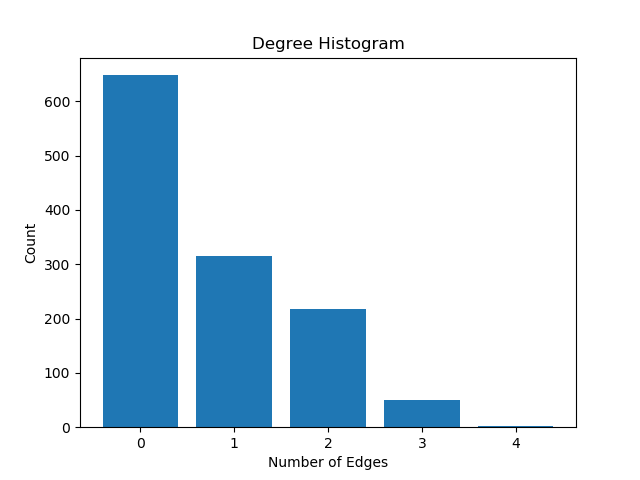

In [55]:
create_histogram(graph_1)

<IPython.core.display.Javascript object>


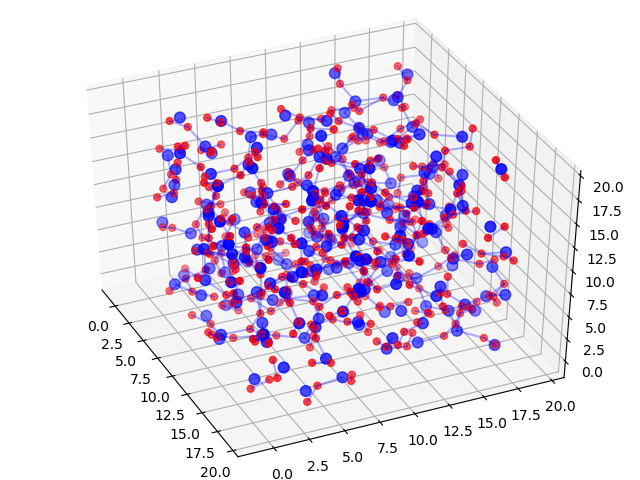

HBox(children=(IntProgress(value=0, max=454), HTML(value='')))

In [56]:
draw_3d_graph(graph_1)

## Slow Preformance

This polygon count isn't that high. Let's try a more robust library...

### Plotly

In [57]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter3d
from plotly.graph_objs import *
import plotly.graph_objs as go

In [58]:
import numpy as np

In [59]:
init_notebook_mode(connected=True)

In [60]:
def draw_plotly_3d_scatter(in_graph):
    # Getting attributes from our graph.
    coords = nx.get_node_attributes(in_graph, 'xyz')
    
    # This gives us a dictionary, which isn't great for
    # the plotting tools. Instead matplotlib would rather
    # have separate lists of x, y and z values.
    x_vals = [x[0] for x in coords.values()]
    y_vals = [x[1] for x in coords.values()]
    z_vals = [x[2] for x in coords.values()]
    c_vals = [color_dict[x[0]] for x in coords.keys()]
    s_vals = [size_dict[x[0]] for x in coords.keys()]
    
    Xe=[]
    Ye=[]
    Ze=[]
    
    # Iterate through the edges, and draw line segments for each set.
    for edge in tqdm_notebook(in_graph.edges()):

        # Assign the node edge indecies.
        node_a = edge[0]
        node_b = edge[1]

        # Assign the x, y, z variables.
        xa, ya, za = xyz_vals[node_a]
        xb, yb, zb = xyz_vals[node_b]
        
        Xe+=[xa, xb, None]
        Ye+=[ya, yb, None]
        Ze+=[za, zb, None]

    # Add the points to the scatter plot.
    trace1 = go.Scatter3d(
        x=x_vals,
        y=y_vals,
        z=z_vals,
        mode='markers',
        hovertext = [x for x in coords.keys()],
        marker=dict(
            sizemode='area',
            color=c_vals,
            size=s_vals,
        opacity=0.8
        ),
    )
    
    trace2 = Scatter3d(
        x=Xe,
        y=Ye,
        z=Ze,
        mode='lines',
        line=Line(color='rgb(125,125,125)', width=1),
        hoverinfo='none'
    )

    # Show the plot.
    data = [trace1, trace2]
    fig = go.Figure(data=data)
    iplot(fig)

In [61]:
draw_plotly_3d_scatter(test_graph)

HBox(children=(IntProgress(value=0, max=432), HTML(value='')))

In [62]:
print('displaying {0} points with {1} edges!'.format(len(graph_1), len(graph_1.edges())))
draw_plotly_3d_scatter(graph_1)

displaying 1233 points with 454 edges!


HBox(children=(IntProgress(value=0, max=454), HTML(value='')))